In [1]:
import os
import sys
#sys.path.append(os.path.join(os.getcwd(), '..'))
from ldm.data.deepfashion import DeepFashionSMPL
from ldm.util import instantiate_from_config
from einops import rearrange
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy

import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from torchvision import transforms as T
from pathlib import Path
from skimage.metrics import structural_similarity as ssim

from ldm.data.deepfashion_inshop import DeepFashionSample
from ldm.data.segm_utils import LipSegmenter
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import pickle
import random


In [2]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    model.eval()
    return model

In [5]:
device = 'cuda:0'
CKPT = 'logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt'
#CONFIG = 'logs/2023-01-31T02-39-11_inshop_lip_clip'
CONFIG = 'configs/deepfashion/inshop_lip_clip.yaml'

# interpolate
#CKPT = 'logs/2023-02-27T01-37-45_lowres/checkpoints/epoch=000003.ckpt'
#CONFIG ='logs/2023-02-27T01-37-45_lowres/configs/2023-02-27T01-37-45-project.yaml'

#high res
#CKPT = 'logs/2023-02-26T00-00-00_highres/checkpoints/epoch=000011.ckpt'
#CONFIG = 'logs/2023-02-26T00-00-00_highres/configs/2023-02-25T23-56-53-project.yaml'

config = OmegaConf.load(CONFIG)
config['data']['params']['test']['params']['data_file'] = 'deepfashion_map.csv'
# create clip image encoder


## Instantiate text and image encoder

In [6]:
clip_image_encoder = instantiate_from_config(config['model']['params']['extra_cond_stages']['style_cond']).to(device)
text_encoder_config = {'target': 'ldm.modules.encoders.modules.FrozenCLIPTextEmbedder', 
                       'params': {'normalize': False}}
clip_text_encoder = instantiate_from_config(text_encoder_config).to(device)
config['model']['params']['extra_cond_stages']['style_cond']['target'] = 'ldm.modules.poses.poses.DummyModel'
config['model']['params']['first_stage_config']['params']['ckpt_path'] = None

In [7]:
model = load_model_from_config(config, f"{CKPT}").to(device)

Loading model from logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt
Global Step: 49921
LatentDiffusion: Running in eps-prediction mode


/home/soon/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(


DiffusionWrapper has 425.29 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.18.layer_norm1.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.17.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.layer_norm2.bias', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.19.layer_norm1.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.5.layer_norm1.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.1

In [8]:
style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
ds = DeepFashionSample(**config['data']['params']['test']['params'])

In [9]:
config['data']['params']['test']['params']

{'folder': '/home/soon/datasets/deepfashion_inshop', 'image_dir': 'img_256', 'data_file': 'deepfashion_map.csv', 'pair_file': ['pairs-test-all.csv']}

In [10]:
def create_batch(batch, repeat=1):
    for k, v in batch.items():
        if type(v)==torch.Tensor:
            temp = batch[k].unsqueeze(0)
            repeat_list = [1]*len(temp.shape)
            repeat_list[0] = repeat
            batch[k] = temp.repeat(repeat_list).to(device)                        
        else:
            batch[k] = [batch[k]]*repeat
    return batch

def generate(model, batch, steps=200):
        
    with torch.no_grad():
        images = model.log_images(batch, ddim_steps=steps, use_ema=True,
                                  unconditional_guidance_scale=3.,
                                  unconditional_guidance_label=["txt"])
        
    for k in images:
        images[k] = images[k].detach().cpu()
        images[k] = torch.clamp(images[k], -1., 1.)
        images[k] = rearrange(images[k].numpy(),'b c h w -> b h w c') *0.5 + 0.5
    return images


def draw_styles(style_batch):
    
    #style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']

    denorm = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],  std = [ 1/0.226862954, 1/0.26130258, 1/0.27577711 ]),
                         T.Normalize(mean = [ -0.48145466, -0.4578275, -0.40821073], std = [ 1., 1., 1. ]),      ])
    rows, cols = 2, 4
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    for i, (name, style) in enumerate(zip(style_names[:-1], style_batch[:-1])):
        row = i//cols
        col = i%cols
        axs[row, col].imshow(T.ToPILImage()(denorm(style)))
        axs[row, col].set_title(name)
        axs[row, col].axis('off')
    plt.show()
            

In [11]:
import re

def convert_fname(long_name):
    gender = 'MEN' if long_name[7:10]  == 'MEN' else 'WOMEN'

    input_list = long_name.replace('fashion','').split('___')
    
    # Define a regular expression pattern to match the relevant parts of each input string
    if gender == 'MEN':
        pattern = r'MEN(\w+)id(\d+)_(\d)(\w+)'
    else:
        pattern = r'WOMEN(\w+)id(\d+)_(\d)(\w+)'
    # Use a list comprehension to extract the matching substrings from each input string, and format them into the desired output format
    output_list = [f'{gender}/{category}/id_{id_num[:8]}/{id_num[8:]}_{view_num}_{view_desc}' for (category, id_num, view_num, view_desc) in re.findall(pattern, ' '.join(input_list))]

    # Print the resulting list of formatted strings
    return output_list

#convert_fname('fashionWOMENShortsid0000478403_4full___fashionWOMENShortsid0000478403_1front')
convert_fname('fashionWOMENBlouses_Shirtsid0000311501_7additional___fashionWOMENBlouses_Shirtsid0000311501_2side')

['WOMEN/Blouses_Shirts/id_00003115/01_7_additional',
 'WOMEN/Blouses_Shirts/id_00003115/01_2_side']

In [12]:
clip_transform = T.Compose([T.ToTensor(),
                           T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                                    std=(0.26862954, 0.26130258, 0.27577711))
                          ])

def get_empty_style():
    return clip_transform(np.zeros((224,224,3)))

In [52]:
def mix_style(s, w, mask=[]):
    style2id = dict(zip(style_names,[x for x in range(len(style_names))]))
    text_dict = dict(zip(style_names, ['' for _ in range(len(style_names))]))
    
    for m in mask:
        s[style2id[m]] = get_empty_style()
        
    with torch.no_grad():        
        for k, v in w.items():
            text_dict[k] = v
        texts = list(text_dict.values())
        text_emb = clip_text_encoder([texts])
        
        image_emb = clip_image_encoder(s.unsqueeze(0).to(device))

        for i, text in enumerate(texts):
            if text != '':                
                image_emb[0,i] = text_emb[0,i]
                
    return image_emb.squeeze(0)

#mix_style(dst_batch['styles'], text_prompt).shape

In [14]:
men = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='MEN' and  'front' in x]
women = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='WOM' and 'front' in x]
len(women)

11147

In [44]:
result_root = 'logs/2023-02-03T22-46-00_inshop_lip_clip_recon_newname/results'
df = pd.read_csv(os.path.join(result_root, 'metrics_png.csv'))
df['dest'] = df['name'].map(lambda x: x.split('___')[1])
df['men'] = df['name'].map(lambda x: x[:10]=='fashionMEN')
check_df = df[df['men']==False]
#.sort_values(by=['SSIM'], ascending=False)
#check_df = df.sort_values(by=['SSIM'], ascending=False)

In [45]:
check_df = check_df[check_df['dest'].map(lambda x: 'full' in x)]

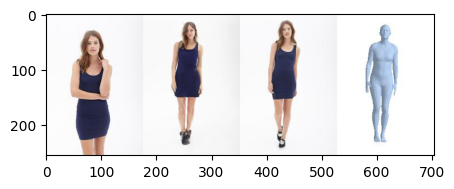

0 fashionWOMENDressesid0000073103_2side___fashionWOMENDressesid0000073103_4full.png


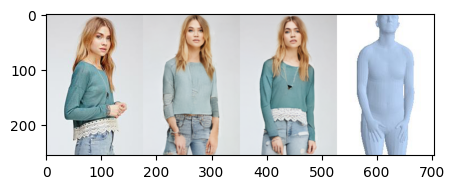

1 fashionWOMENTees_Tanksid0000077807_1front___fashionWOMENTees_Tanksid0000077807_4full.png


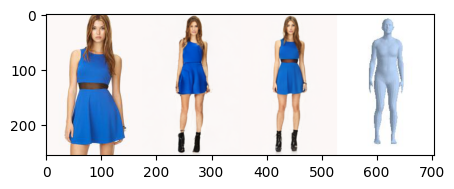

2 fashionWOMENDressesid0000048104_1front___fashionWOMENDressesid0000048104_4full.png


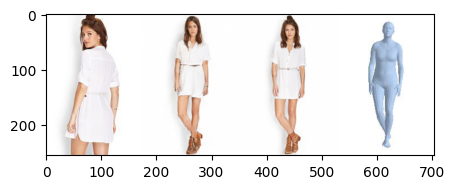

3 fashionWOMENDressesid0000465104_3back___fashionWOMENDressesid0000465104_4full.png


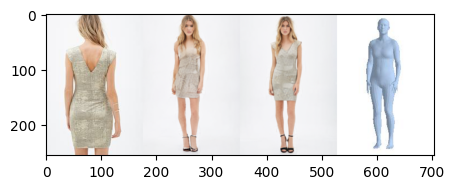

4 fashionWOMENDressesid0000676702_3back___fashionWOMENDressesid0000676702_4full.png


In [166]:
start_idx = 0
for i in range(start_idx, start_idx+5):
    fname = check_df.iloc[i]['name']
    
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(os.path.join(result_root,'concats',fname)))
    plt.show()
    print(i, fname)

In [53]:
def get_coord(batch_mask):
    mask = batch_mask[0].cpu().numpy()
    mask[mask==-1] = 0
    x = np.nonzero(np.mean(mask,1))[0]
    xmin, xmax = x[0], x[-1]
    y = np.nonzero(np.mean(mask,0))[0]
    ymin, ymax = y[0], y[-1]

    return np.array([xmin, xmax, ymin, ymax])

def get_mask(mask, coord):
    device = mask.device
    xmin, xmax, ymin, ymax = coord
    new_mask = np.ones_like(mask.cpu().numpy())*(-1)
    new_mask[0,xmin:xmax+1, ymin:ymax+1] = -0.99215686
    #return new_mask
    return torch.tensor(new_mask).to(device)

def interp_mask(src_mask, dst_mask, alpha):    
    coord_1 = get_coord(src_mask)
    coord_2 = get_coord(dst_mask)

    coord = (alpha * coord_1 + (1 - alpha) * coord_2).astype(np.int32)
    print(coord)
    #coord = np.array([ 0, 31,  12, 19])
    new_mask = get_mask(src_mask, coord)
    return new_mask


In [202]:
select_id = 98
name_string = check_df.iloc[select_id]['name']
dst_id, src_id  = convert_fname(name_string.split('.')[0])
print(src_id, dst_id)

WOMEN/Dresses/id_00000388/06_4_full WOMEN/Dresses/id_00000388/06_7_additional


In [223]:
style_id = 'WOMEN/Tees_Tanks/id_00004975/04_4_full.jpg'
#style_id = convert_fname('fashionMENTees_Tanksid0000481201_1front')[0]+'.jpg'
style_batch = ds[style_id]

print(style_batch['txt'])
style2_id = convert_fname('fashionWOMENDressesid0000676702_4full')[0]+'.jpg'
#style2_id = 'WOMEN/Sweaters/id_00003547/01_1_front.jpg'
style2_batch = ds[style2_id]
print(style2_batch['txt'])
#convert_fname('fashionMENTees_Tanksid0000260306_1front')

The tank shirt this woman wears has no sleeves and it is with cotton fabric and solid color patterns. This woman wears a three-point shorts, with cotton fabric and solid color patterns. This female wears a ring.
The tank shirt this person wears has sleeves cut off and its fabric is cotton. The pattern of it is other. It has a v-shape neckline. This person wears a three-point shorts, with cotton fabric and other patterns. There is an accessory on her wrist. The person is wearing a ring on her finger.


WOMEN/Blouses_Shirts/id_00003541/01_1_front WOMEN/Blouses_Shirts/id_00003541/01_1_front
The sweater this woman wears has long sleeves, its fabric is cotton, and it has pure color patterns. The sweater has a round neckline. The female has a hat in her head. There is a ring on her finger. The female has neckwear. There is an accessory on her wrist.
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (8, 4, 32, 24), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.77it/s]


Plotting: Restored training weights


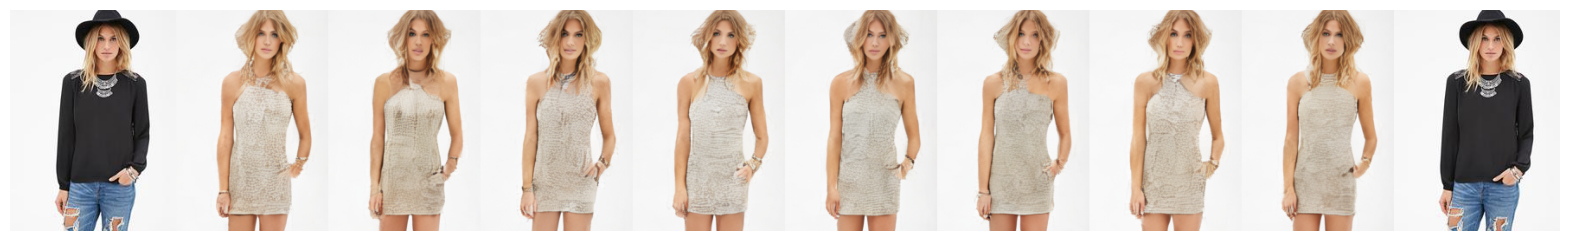

In [228]:
#src_id = 'WOMEN/Dresses/id_00006168/08_4_full'
#dst_id = 'MEN/Tees_Tanks/id_00007466/08_2_side'
#dst_id = random.choice(men)
#dst_id = random.choice(women)
#dst_id = 'WOMEN-Jackets_Coats-id_00007450-02_1_front'.replace('-','/')
name_string ='fashionWOMENBlouses_Shirtsid0000354101_1front'
src_id  = convert_fname(name_string)[0]
#dst_id = convert_fname('fashionWOMENDressesid0000465104_4full')[0]
#src_id = dst_id
dst_id = src_id

pose_interp = []
#for alpha in np.arange(1.0-0.13333,0.13333,-0.13333):
for alpha in [1.0]:
    src_batch = ds[src_id+'.jpg']
    dst_batch = ds[dst_id+'.jpg']
    
    src_image = np.uint8(((src_batch['image']+1)/2)*255)
    dst_image = np.uint8(((dst_batch['image']+1)/2)*255)
    src_smpl_image = Image.fromarray(np.uint8(((src_batch['smpl_image']+1)/2)*255))
    dst_smpl_image = Image.fromarray(np.uint8(((dst_batch['smpl_image']+1)/2)*255))
    print(src_id, dst_id)
    #dst_batch['txt'] = src_batch['txt']
    #src_batch['styles'] = dst_batch['styles']

    text_style = {#'face': "European white male",
                  #'hair':'blonde hair',
                  #'headwear': 'a red hat',
                  #'background':'brown flooring',
                  #'top':'a red and blue short sleeve shirt in plaid pattern',
                  #'outer':'red suit jacket',
                  #'bottom':'red short skirt',
                  #'shoes':'black shoes',
                  #'accesories':'a white belt'
                    }
 
    style_mask = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
    style_mask = ['headwear']
    
    
    #for transfer_id in [0,1]:
    #    src_batch['styles'][transfer_id] = style_batch['styles'][transfer_id]
    
    for transfer_id in [4,6]:
        src_batch['styles'][transfer_id] = style2_batch['styles'][transfer_id]
        
        
    src_batch['styles'] = mix_style(src_batch['styles'], text_style, mask=style_mask)
    
    #dst_batch['smpl'][0,72:82] = src_batch['smpl'][0,72:82]
    src_batch['smpl'] = dst_batch['smpl']
    src_batch['person_mask'] = dst_batch['person_mask']
    
    
    
    #src_batch['person_mask'] = dst_batch['person_mask']
    print(src_batch['txt'])
    #dst_batch['styles'] = clip_image_encoder(dst_batch['styles'].unsqueeze(0).to(device)).squeeze()
    src_batch['txt'] = 'The tank shirt this person wears has sleeves cut off and its fabric is cotton. This person wears a three-point shorts, with cotton fabric and other patterns. There is a ring on her finger. The female has neckwear. There is an accessory on her wrist.'
    #alphas = np.arange(1.0,-0.1,-0.1)
    alphas = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    repeat = len(alphas)
    src_batch = create_batch(src_batch, repeat)
    
    #pose interpolation   
    '''
    for i, alpha in enumerate(alphas):    
        src_batch['smpl'][i] = alpha * src_batch['smpl'][i] + (1 - alpha) * dst_batch['smpl'].to(device)
        src_batch['person_mask'][i] = interp_mask(src_batch['person_mask'][i], dst_batch['person_mask'], alpha)
    '''        
    
    log = generate(model, src_batch, 200)
    samples = [np.array(T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(x*255)))) for x in log['samples']]
    #plt.figure(figsize=(30,30))
    #plt.imshow(np.hstack((src_image, np.hstack(samples))))
    
    #sample = T.CenterCrop(size=(2*256, 2*176))(Image.fromarray(np.uint8(log['samples'][0]*255)))
    #sample.save(os.path.join(folder, j))
    plt.figure(figsize=(20,20))
    concat = np.hstack((src_image, np.hstack(samples), dst_image))
    #pose_interp.append(np.array(sample))
    plt.imshow(concat)
    plt.axis('off')
    plt.show()

#concat = np.hstack((src_image, np.hstack(pose_interp), dst_image))
#plt.figure(figsize=(10,10))
#plt.imshow(concat)
#plt.axis('off')
#plt.show()


In [229]:
folder = './figures/edit/'+src_id.replace('/','-')
os.makedirs(folder,exist_ok=True)

offset = 0
for i, sample in enumerate(samples):
    path = os.path.join(folder,f'{i+offset}.jpg')
    #assert not os.path.isfile(path)
    Image.fromarray(sample).save(path)


In [192]:
#folder = "./figures/interp/1/"
os.makedirs(folder, exist_ok=True)
src_name = os.path.join(folder, src_id.replace('/','-')+'.jpg')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.jpg')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

smpl_image = src_batch['smpl_image'][0].cpu().numpy()*0.5+0.5
smpl_image = Image.fromarray((smpl_image*255).astype(np.uint8))
smpl_image = T.CenterCrop((256,176))(smpl_image)
smpl_image.save(os.path.join(folder,f'smpl.jpg'))
smpl_image = dst_batch['smpl_image'].cpu().numpy()*0.5+0.5
smpl_image = Image.fromarray((smpl_image*255).astype(np.uint8))
smpl_image = T.CenterCrop((256,176))(smpl_image)
smpl_image.save(os.path.join(folder,f'smpl_dst.jpg'))

with open(os.path.join(folder, 'caption.txt'), 'w') as f:
    f.write(src_batch['txt'][0])


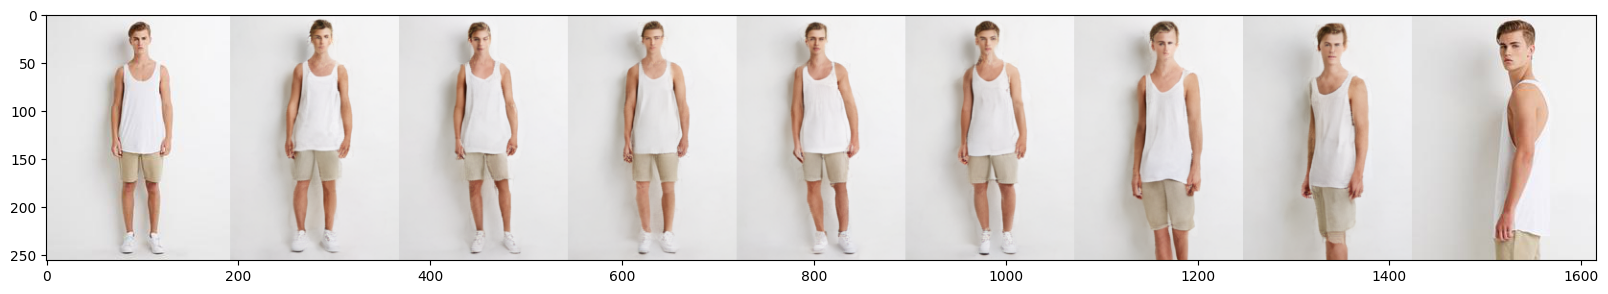

In [111]:
plt.figure(figsize=(20,20))
plt.imshow(concat)

In [108]:
alphas

array([1.   , 0.925, 0.85 , 0.775, 0.7  , 0.625, 0.55 ])

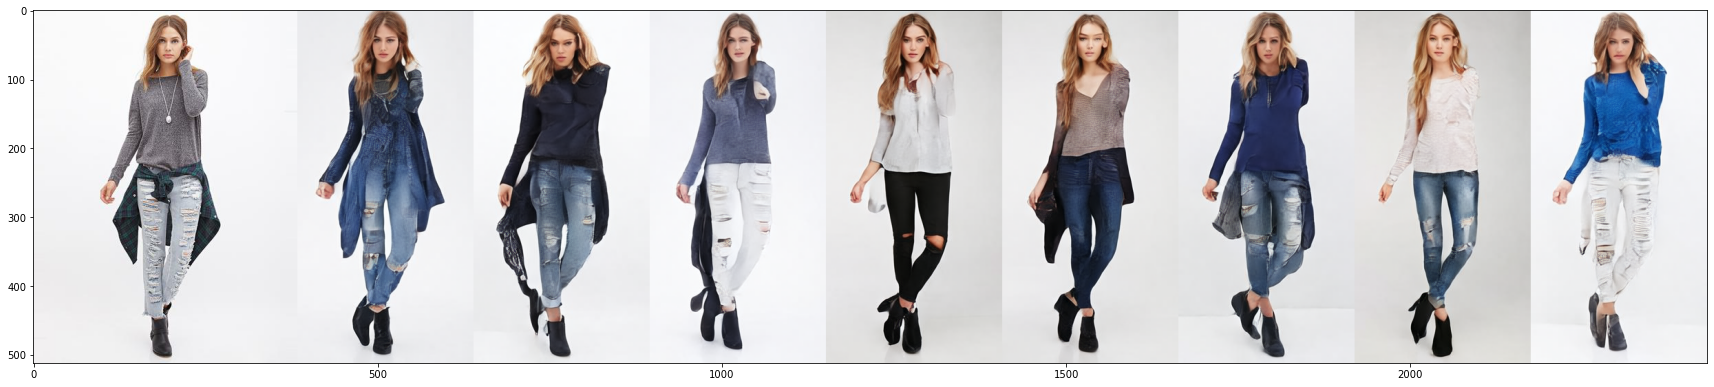

In [128]:
plt.figure(figsize=(30,30))  
plt.imshow(np.hstack((src_image, np.hstack(samples))))

In [608]:
folder = "./figures/512/"
os.makedirs(folder,exist_ok=True)
path = os.path.join(folder,name_string)
#assert not os.path.isfile(path)
Image.fromarray(pose_interp[0]).save(path)

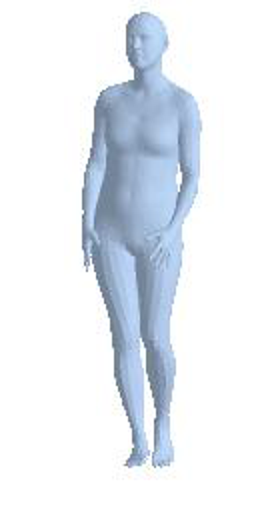

In [22]:
#for i in range(len(pose_interp)):
#    Image.fromarray(pose_interp[i]).save(os.path.join(folder,f'{i}.jpg'))

In [23]:
folder = "./figures/interp/0/"
os.makedirs(folder,exist_ok=True)
name = 'panda'
path = os.path.join(folder, name+'.png')
assert not os.path.isfile(path)
sample.save(path)

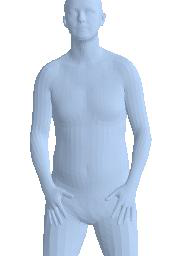

In [24]:
src_smpl_image = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(((src_batch['smpl_image'][0].cpu().numpy()+1)/2)*255)))
src_smpl_image

In [25]:
src_name = os.path.join(folder, src_id.replace('/','-')+'.png')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.png')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

src_smpl_image.save(os.path.join(folder,'src_smpl.png'))

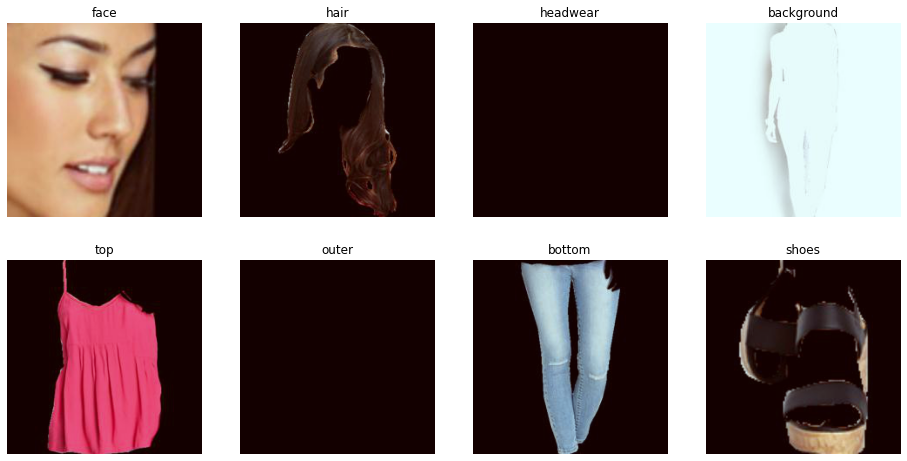

In [65]:
draw_styles(dst_batch['styles'])

In [ ]:
style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
style2id = dict(zip(style_names, [i for i in range(len(style_names))]))


#dst_id = 'MEN/Tees_Tanks/id_00005955/06_1_front'
#dst_id = 'WOMEN/Dresses/id_00000269/13_7_additional'
dst_id = 'WOMEN/Jackets_Coats/id_00001313/02_4_full'
#dst_id = 'fashionWOMENDressesid0000182607_2side'
#dst_id = convert_fname(dst_id)[0]

#src_id = 'MEN/Sweaters/id_00000702/06_7_additional'
#src_id = 'WOMEN/Pants/id_00003761/01_7_additional'
src_id = 'WOMEN/Jackets_Coats/id_00000187/10_7_additional'
#src_id = 'fashionWOMENDressesid0000182607_2side'
#src_id = convert_fname(src_id)[0]

src_batch = ds[src_id+'.jpg']
dst_batch = ds[dst_id+'.jpg']
print(src_id, dst_id)

src_image = (((src_batch['image']+1)/2).numpy()*255).astype(np.uint8)
dst_image = (((dst_batch['image']+1)/2).numpy()*255).astype(np.uint8)

dst_batch['txt'] = src_batch['txt']
#dst_batch['txt'] = \
#'The upper clothing is sleeveless, cotton fabric and solid color patterns. It has a round neckline. The outer clothing the lady wears is sleeveless with denim and solid color patterns. This person wears a ring. There is an accessory on her wrist.'

#transfer = ['headwear', 'top', 'outer', 'bottom','shoes', 'accesories']
transfer = ['outer', 'headwear']
transfer_id = [style2id[x] for x in transfer]
for t in transfer_id:
    dst_batch['styles'][transfer_id] = src_batch['styles'][transfer_id]

log = generate(model, dst_batch, 200)

sample = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(log['samples'][0]*255)))

concat = np.hstack((dst_image, np.array(sample), src_image))
#sample.save(os.path.join(folder, j))
plt.figure(figsize=(12,6))
plt.imshow(concat)
plt.axis('off')
plt.show()


In [58]:
x = Image.open('figures/outer.jpg')
dim = min(x.size)

In [59]:
T.CenterCrop((dim,dim))(x).resize((224,224)).save('figures/outer.jpg')